Load the data from the load notebook.


In [1]:
%run "cog_wfdb-dataframe-to-cache.ipynb"

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Using cached ML data...


Ensure tflearn and tensorflow is installed

In [2]:
!pip3 install tflearn tensorflow

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Remove columns that aren't needed.

In [3]:
def isolate_millivolt_features(anEcgDataFrame):
    # trim data down
    data = anEcgDataFrame

    columns = data.drop('labels', axis=1).columns.tolist()
    columns = list(filter(lambda x: not re.search('_max|_var', str(x)), columns))

    samples = data[columns]
    samples = samples.fillna(0)

    labels = data['labels']

    return samples, labels, columns

print('isolate_millivolt_features....')
from IPython.display import display
display(samples)
milivoltFeatures, labels, columns = isolate_millivolt_features(samples)



isolate_millivolt_features....


,0,1,2,3,4,5,6,7,8,9,...,717,718,719,720,721,MLII_milliVolts_max,MLII_milliVolts_var,V5_milliVolts_max,V5_milliVolts_var,labels
0,-0.390,0.195,-0.375,0.200,-0.365,0.190,-0.360,0.195,-0.360,0.195,...,0.075,-0.105,0.095,-0.120,0.110,4.980139,0.470124,0.088159,5.037822,0.0
1,-0.425,0.275,-0.430,0.275,-0.455,0.275,-0.460,0.280,-0.465,0.295,...,0.140,0.330,0.175,0.360,0.185,5.753898,0.977418,0.202634,6.372375,0.0
2,0.475,-0.260,0.305,-0.245,0.090,-0.225,-0.235,-0.175,-0.580,-0.125,...,-0.030,0.715,-0.095,0.790,-0.170,3.653131,0.476768,0.075920,0.002317,0.0
3,-0.005,0.030,-0.040,0.010,-0.025,-0.005,-0.025,-0.005,-0.030,0.000,...,0.050,-0.230,0.045,-0.230,0.035,5.398240,0.502730,0.011412,0.063016,0.0
4,-1.080,-0.420,-1.085,-0.440,-1.075,-0.430,-1.090,-0.445,-1.075,-0.450,...,-0.440,-0.950,-0.435,-0.955,-0.430,9.944695,2.853296,0.014496,2.044262,0.0
5,-0.390,0.070,-0.390,0.075,-0.400,0.075,-0.405,0.065,-0.400,0.065,...,0.115,-0.180,0.130,-0.180,0.130,2.986583,0.167355,0.008286,0.000014,0.0
6,-0.375,0.130,-0.385,0.115,-0.360,0.120,-0.335,0.150,-0.300,0.185,...,0.175,-0.265,0.150,-0.275,0.110,1.975509,0.372467,0.423735,0.151193,0.0
7,-0.980,-0.420,-0.985,-0.425,-0.970,-0.420,-0.975,-0.425,-0.980,-0.440,...,-0.435,-1.060,-0.405,-1.045,-0.410,6.387797,1.497018,0.004689,0.583119,0.0
8,-0.135,0.035,-0.145,0.040,-0.155,0.025,-0.175,0.035,-0.165,0.065,...,-0.400,0.730,-0.625,0.450,-0.795,29.044959,12.346140,0.058948,0.315265,0.0
9,0.085,0.105,0.090,0.115,0.095,0.130,0.075,0.115,0.055,0.105,...,0.065,-0.010,0.060,0.000,0.050,0.008802,0.061779,0.052118,0.004187,0.0


In [4]:
def draw_confusion_matrices(confusion_matricies,class_names):
    import matplotlib.pyplot as plt
    class_names = class_names.tolist()
    for cm in confusion_matricies:
        classifier, cm = cm[0], cm[1]
        print(cm)
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm)
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    

Show tensorflow graph

In [5]:
from IPython.display import clear_output, Image, display, HTML
import tensorflow as tf

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

Process ECG data

Training Step: 30  | total loss: 0.16712
| Adam | epoch: 030 | loss: 0.16712 - acc: 0.9762 -- iter: 1452/1452
Training Step: 30  | total loss: 0.16712
| Adam | epoch: 030 | loss: 0.16712 - acc: 0.9762 -- iter: 1452/1452
--


Train Accuracy: 0.993802
Vdalidation Accuracy: 0.986264
----- validation
classification
             precision    recall  f1-score   support

          0       1.00      0.97      0.99       200
          1       0.97      1.00      0.98       164

avg / total       0.99      0.99      0.99       364

confusion matrix
----- training
classification
             precision    recall  f1-score   support

          0       1.00      0.99      0.99       708
          1       0.99      1.00      0.99       744

avg / total       0.99      0.99      0.99      1452

confusion matrix
[[195   5]
 [  0 164]]


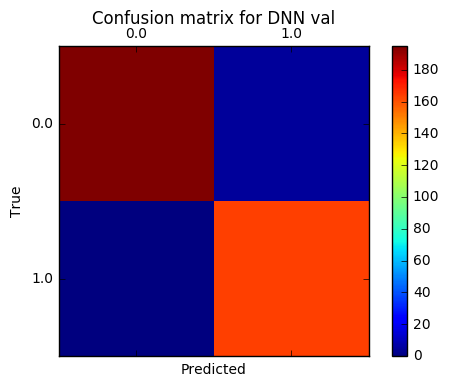

[[700   8]
 [  1 743]]


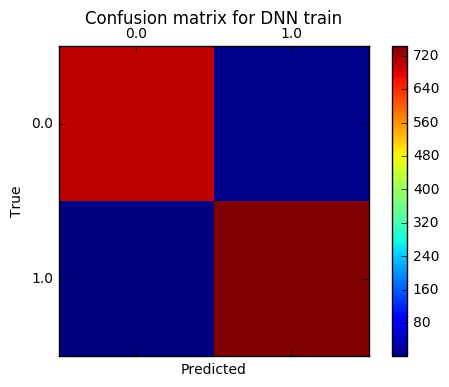

In [6]:
def exampleNeuralNetTfDnn(samples, labels):
    from sklearn.cross_validation import train_test_split
    x_train, x_val, y_train, y_val = \
        train_test_split(samples.values, labels.values, test_size=0.20,
                         random_state=np.random.randint(0, 100))

    # convert into 2 columns, isGood, isBad
    from tflearn.data_utils import to_categorical
    y_train = to_categorical(y_train, 2)
    y_val = to_categorical(y_val, 2)

    '''
            x_train 	: x training data
            y_train 	: y training labels
            x_val 		: x validation data
            y_val 		: y validation labels
    '''

    import tflearn
    graph_to_use = tf.Graph()
    with graph_to_use.as_default():
        # define neural net
        net = tflearn.input_data(shape=[None, x_train.shape[1]])
        net = tflearn.fully_connected(net, 50, activation='relu')
        net = tflearn.fully_connected(net, 200, activation='relu')
        net = tflearn.fully_connected(net, 10, activation='tanh')
        net = tflearn.fully_connected(net, 2, activation='softmax');
        net = tflearn.regression(net, learning_rate=0.005)

        # define model
        model = tflearn.DNN(net, tensorboard_verbose=3)

        # train
        model.fit(x_train, y_train, show_metric=True, batch_size=x_train.shape[0], n_epoch=30,run_id='ECG DNN' )
              # validation_set=(x_val,y_val), validation_batch_size=x_val.shape[0]

        show_graph(graph_to_use.as_graph_def())        
    
        # print accuracy statistics
        result = model.evaluate(x_train, y_train, batch_size=x_train.shape[0])
        accuracy_score = result[0]
        print("Train Accuracy: %f" % accuracy_score)

        result = model.evaluate(x_val, y_val, batch_size=x_val.shape[0])
        accuracy_score = result[0]
        print("Vdalidation Accuracy: %f" % accuracy_score)

        # print detail statistics
        import sklearn.metrics as skmetric
        from sklearn.metrics import classification_report

        print("----- validation")
        pred = model.predict(x_val)
        pred = np.around(np.asarray(pred))
        print("classification")
        print(classification_report(np.asarray(y_val.argmax(axis=1)), np.asarray(pred.argmax(axis=1))))
        print("confusion matrix")
        cm_val = skmetric.confusion_matrix(np.asarray(y_val.argmax(axis=1)), np.asarray(pred.argmax(axis=1)))

        print("----- training")
        pred = model.predict(x_train)
        pred = np.around(np.asarray(pred))
        print("classification")
        print(classification_report(y_train.argmax(axis=1), pred.argmax(axis=1)))
        print("confusion matrix")
        cm_train = (skmetric.confusion_matrix(np.asarray(y_train.argmax(axis=1)), np.asarray(pred.argmax(axis=1))))

        class_names = np.unique(y_train)
        confusion_matrices = [
        ( "DNN val", cm_val ),
        ( "DNN train", cm_train),
        ]
        %matplotlib inline
        draw_confusion_matrices(confusion_matrices,class_names)

exampleNeuralNetTfDnn(milivoltFeatures, labels)

In [ ]:
import webbrowser

# generate an URL
url = 'http://ubuntu:30000'
print(url)
webbrowser.open(url)

http://ubuntu:30000


False

In [ ]:
%run /opt/conda/lib/python3.5/site-packages/tensorflow/tensorboard/tensorboard.py --logdir=/tmp/tflearn_logs/ --port 30000

INFO:tensorflow:Starting TensorBoard in directory /home/jovyan/work
INFO:tensorflow:TensorBoard path_to_run is: {'/tmp/tflearn_logs': None}
INFO:tensorflow:Event Multiplexer initializing.
INFO:tensorflow:Event Multiplexer done initializing
INFO:tensorflow:TensorBoard reload process beginning
INFO:tensorflow:TensorBoard is tag: b'39'
Starting TensorBoard b'39' on port 30000
(You can navigate to http://172.17.0.39:30000)
INFO:tensorflow:Starting AddRunsFromDirectory: /tmp/tflearn_logs
INFO:tensorflow:Adding events from directory /tmp/tflearn_logs/ECG DNN
INFO:tensorflow:Constructing EventAccumulator for /tmp/tflearn_logs/ECG DNN
INFO:tensorflow:Adding events from directory /tmp/tflearn_logs/0BK0V4
INFO:tensorflow:Constructing EventAccumulator for /tmp/tflearn_logs/0BK0V4
INFO:tensorflow:Adding events from directory /tmp/tflearn_logs/OFQ15F
INFO:tensorflow:Constructing EventAccumulator for /tmp/tflearn_logs/OFQ15F
INFO:tensorflow:Adding events from directory /tmp/tflearn_logs/KTIPGE
INFO: